<a href="https://colab.research.google.com/github/agape1225/BITCOIN-AUTO-TRADE-SERVER/blob/main/BITCOIN_AUTO_TRADE_%EB%8B%A4%EC%B0%A8%EC%9B%90_%ED%95%99%EC%8A%B5_%EB%B0%8F_%EB%8B%A4%EC%B0%A8%EC%9B%90_%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
maindf = pd.read_csv('BTC_KRW.csv')
maindf = maindf.iloc[::-1]

# 필요한 열 선택
closedf = maindf[['시가', '종가', '고가', '저가', '거래량']]

# 데이터 전처리
closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
closedf['고가'] = closedf['고가'].str.replace(',', '').astype(float)
closedf['저가'] = closedf['저가'].str.replace(',', '').astype(float)
closedf['거래량'] = closedf['거래량'].str.replace('K', '').astype(float)
#closedf['변동 %'] = closedf['변동 %'].str.replace('%', '').astype(float)

<ipython-input-2-db74671c012b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
<ipython-input-2-db74671c012b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
<ipython-input-2-db74671c012b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
closedf.shape

(2298, 5)

In [ ]:
closedf[0:5]

,시가,종가,고가,저가,거래량
2297,3104000.0,3206000.0,3281000.0,3081000.0,21.58
2296,3206000.0,4175000.0,4314000.0,3206000.0,34.68
2295,4175000.0,4199000.0,4840000.0,3102000.0,35.91
2294,4199000.0,3227000.0,4200000.0,2900000.0,36.65
2293,3227000.0,3152000.0,3288000.0,2460000.0,33.75


In [3]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
closedf = scaler.fit_transform(closedf)

# 데이터 분할
training_size = int(len(closedf) * 0.60)
test_size = len(closedf) - training_size
train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :]

In [ ]:
train_data.shape

(1378, 5)

In [ ]:
train_data[0:5]

array([[0.01123709, 0.01252349, 0.01181667, 0.01635055, 0.17603852],
       [0.01252349, 0.0247443 , 0.02470645, 0.01794603, 0.28295111],
       [0.0247443 , 0.02504698, 0.03126989, 0.01661859, 0.29298947],
       [0.02504698, 0.01278834, 0.02328396, 0.01404028, 0.29902881],
       [0.01278834, 0.01184245, 0.01190402, 0.00842417, 0.27536114]])

In [4]:
# 시계열 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

# 시계열 데이터셋 생성
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape

((1362, 15, 5), (1362, 5))

In [ ]:
X_test.shape, y_test.shape

((904, 15, 5), (904, 5))

In [ ]:
X_train[0], y_train[0]

(array([[0.01123709, 0.01252349, 0.01181667, 0.01635055, 0.17603852],
        [0.01252349, 0.0247443 , 0.02470645, 0.01794603, 0.28295111],
        [0.0247443 , 0.02504698, 0.03126989, 0.01661859, 0.29298947],
        [0.02504698, 0.01278834, 0.02328396, 0.01404028, 0.29902881],
        [0.01278834, 0.01184245, 0.01190402, 0.00842417, 0.27536114],
        [0.01184245, 0.01180462, 0.01330156, 0.01340209, 0.18215947],
        [0.01180462, 0.01252349, 0.01255288, 0.0148827 , 0.17179466],
        [0.01252349, 0.01174156, 0.01205376, 0.01659306, 0.16126663],
        [0.01174156, 0.01036688, 0.01025692, 0.01484441, 0.19048396],
        [0.01036688, 0.01171634, 0.01028188, 0.01569959, 0.11817514],
        [0.01171634, 0.01205685, 0.01075604, 0.01599316, 0.1694279 ],
        [0.01205685, 0.01131276, 0.01075604, 0.01531667, 0.14478087],
        [0.01131276, 0.01069478, 0.00980771, 0.01599316, 0.09907778],
        [0.01069478, 0.01229648, 0.01071861, 0.01608251, 0.14780054],
        [0.01229648,

In [5]:
# 데이터의 차원을 3차원으로 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [ ]:
X_train.shape, X_test.shape

((1362, 15, 5), (904, 15, 5))

In [6]:
# LSTM 모델 정의 및 학습
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation="tanh"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=1)

Epoch 1/500
43/43 [==============================] - 4s 16ms/step - loss: 0.0055 - val_loss: 0.0521
Epoch 2/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0493
Epoch 3/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0479
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0483
Epoch 5/500
43/43 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0475
Epoch 6/500
43/43 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0476
Epoch 7/500
43/43 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0476
Epoch 8/500
43/43 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0479
Epoch 9/500
43/43 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0478
Epoch 10/500
43/43 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0474
Epo

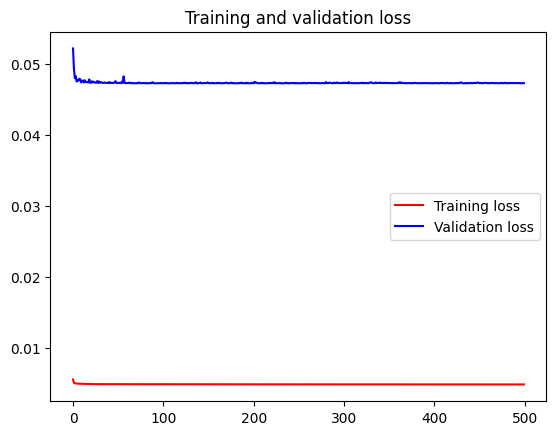

In [7]:
# 학습 과정 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [ ]:
X_train.shape, X_test.shape

((1362, 15, 5), (904, 15, 5))

In [ ]:
print(X_train.shape)

(1362, 15, 5)
[[[0.01123709 0.01252349 0.01181667 0.01635055 0.17603852]
  [0.01252349 0.0247443  0.02470645 0.01794603 0.28295111]
  [0.0247443  0.02504698 0.03126989 0.01661859 0.29298947]
  ...
  [0.01131276 0.01069478 0.00980771 0.01599316 0.09907778]
  [0.01069478 0.01229648 0.01071861 0.01608251 0.14780054]
  [0.01229648 0.01484406 0.01391298 0.01767799 0.26842406]]

 [[0.01252349 0.0247443  0.02470645 0.01794603 0.28295111]
  [0.0247443  0.02504698 0.03126989 0.01661859 0.29298947]
  [0.02504698 0.01278834 0.02328396 0.01404028 0.29902881]
  ...
  [0.01069478 0.01229648 0.01071861 0.01608251 0.14780054]
  [0.01229648 0.01484406 0.01391298 0.01767799 0.26842406]
  [0.01484406 0.01302796 0.01317678 0.01792051 0.15294214]]

 [[0.0247443  0.02504698 0.03126989 0.01661859 0.29298947]
  [0.02504698 0.01278834 0.02328396 0.01404028 0.29902881]
  [0.01278834 0.01184245 0.01190402 0.00842417 0.27536114]
  ...
  [0.01229648 0.01484406 0.01391298 0.01767799 0.26842406]
  [0.01484406 0.0130

In [ ]:
# 예측 결과 역변환
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

29/29 [==============================] - 0s 6ms/step


In [ ]:
train_predict.shape, test_predict.shape, y_train.shape, y_test.shape

((1362, 1), (904, 1), (1362,), (904,))

In [ ]:
onedf = maindf[['종가']]
onedf['종가'] = onedf['종가'].str.replace(',', '').astype(float)
# 데이터 정규화
scalerone = MinMaxScaler(feature_range=(0, 1))
onedf = scalerone.fit_transform(onedf)
onedf.shape

<ipython-input-4-96327c31b56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onedf['종가'] = onedf['종가'].str.replace(',', '').astype(float)


(2298, 1)

In [ ]:
# 예측 결과 역변환 시 shape 문제 해결
train_predict = scalerone.inverse_transform(train_predict)
test_predict = scalerone.inverse_transform(test_predict)
original_ytrain = scalerone.inverse_transform(y_train.reshape(-1,1))
original_ytest = scalerone.inverse_transform(y_test.reshape(-1,1))

print(X_train.shape, X_test.shape, train_predict.shape, test_predict.shape)

(1362, 15, 6) (904, 15, 6) (1362, 1) (904, 1)


In [ ]:
final_predict = train_predict.tolist() + test_predict.tolist()

In [ ]:
len(final_predict)

2266

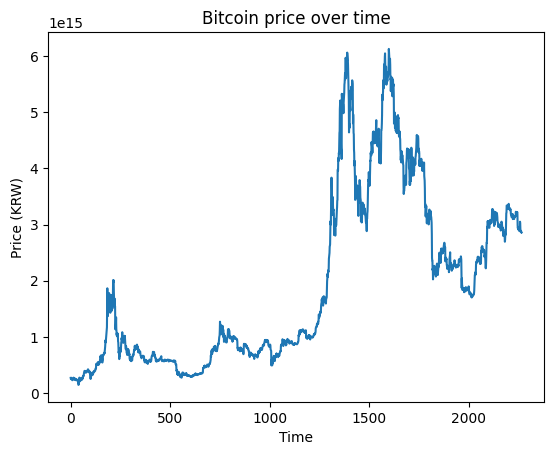

In [ ]:
plt.plot(final_predict)
plt.xlabel("Time")
plt.ylabel("Price (KRW)")
plt.title("Bitcoin price over time")
plt.show();

In [ ]:
  look_back=15
  trainPredictPlot = np.empty_like(closedf)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  print("Train predicted data: ", trainPredictPlot.shape)

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(closedf)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
  print("Test predicted data: ", testPredictPlot.shape)

Train predicted data:  (2298, 6)
Test predicted data:  (2298, 6)


In [ ]:
  plotdf = pd.DataFrame({'date': maindf['날짜'],
                        'original_close': maindf['종가']})

In [ ]:
plt.plot(y)
plt.xlabel("Time")
plt.ylabel("Price (KRW)")
plt.title("Bitcoin price over time")
plt.show();

In [ ]:
  # shift train predictions for plotting

  look_back=time_step
  trainPredictPlot = np.empty_like(closedf)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  print("Train predicted data: ", trainPredictPlot.shape)

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(closedf)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
  print("Test predicted data: ", testPredictPlot.shape)

  names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


  plotdf = pd.DataFrame({'date': maindf['날짜'],
                        'original_close': maindf['종가'],
                        'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                        'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

  fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                            plotdf['test_predicted_close']],
                labels={'value':'Stock price','date': 'Date'})
  fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                    plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
  fig.for_each_trace(lambda t:  t.update(name = next(names)))

  fig.update_xaxes(showgrid=False)
  fig.update_yaxes(showgrid=False)
  fig.show()

Train predicted data:  (2298, 6)
Test predicted data:  (2298, 6)


ValueError: ignored

<ipython-input-9-889582c69d3c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
<ipython-input-9-889582c69d3c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
<ipython-input-9-889582c69d3c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Epoch 1/200
43/43 [==============================] - 4s 22ms/step - loss: 0.0213 - val_loss: 0.0475
Epoch 2/200
43/43 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0140
Epoch 3/200
43/43 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 4/200
43/43 [==============================] - 0s 11ms/step - loss: 6.1942e-04 - val_loss: 0.0028
Epoch 5/200
43/43 [==============================] - 0s 11ms/step - loss: 5.8241e-04 - val_loss: 0.0026
Epoch 6/200
43/43 [==============================] - 0s 9ms/step - loss: 5.5916e-04 - val_loss: 0.0027
Epoch 7/200
43/43 [==============================] - 0s 11ms/step - loss: 5.4059e-04 - val_loss: 0.0024
Epoch 8/200
43/43 [==============================] - 0s 10ms/step - loss: 5.2175e-04 - val_loss: 0.0024
Epoch 9/200
43/43 [==============================] - 0s 12ms/step - loss: 4.9919e-04 - val_loss: 0.0023
Epoch 10/200
43/43 [==============================] - 0s 9ms/step - loss: 4.7

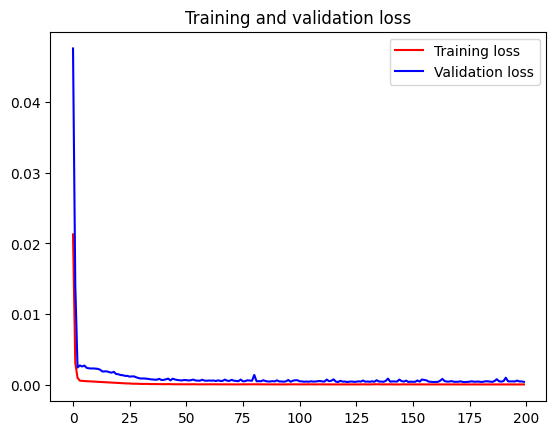

In [ ]:
# 데이터 불러오기
maindf = pd.read_csv('BTC_KRW.csv')
maindf = maindf.iloc[::-1]

# 필요한 열 선택
closedf = maindf[['종가', '시가', '고가', '저가', '거래량', '변동 %']]

# 데이터 전처리
closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
closedf['고가'] = closedf['고가'].str.replace(',', '').astype(float)
closedf['저가'] = closedf['저가'].str.replace(',', '').astype(float)
closedf['거래량'] = closedf['거래량'].str.replace('K', '').astype(float)
closedf['변동 %'] = closedf['변동 %'].str.replace('%', '').astype(float)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
closedf = scaler.fit_transform(closedf)

# 데이터 분할
training_size = int(len(closedf) * 0.60)
test_size = len(closedf) - training_size
train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :]

# 시계열 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 시계열 데이터셋 생성
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 데이터의 차원을 3차원으로 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# LSTM 모델 정의 및 학습
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), activation="tanh"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

# 학습 과정 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend(loc=0)
# plt.show()

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#print(X_train.shape)
X_train.shape, X_test.shape, train_predict.shape, test_predict.shape

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#print(X_train.shape)
X_train.shape, X_test.shape, train_predict.shape, test_predict.shape

29/29 [==============================] - 0s 3ms/step


((1362, 15, 6), (904, 15, 6), (1362, 1), (904, 1))

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

ValueError: ignored

In [ ]:
maindf=pd.read_csv('BTC_KRW.csv')
maindf = maindf.iloc[::-1]

closedf = maindf[['날짜','종가', '시가', '고가', '저가', '거래량', '변동 %']]
closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float).copy()
closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float).copy()
closedf['고가'] = closedf['고가'].str.replace(',', '').astype(float).copy()
closedf['저가'] = closedf['저가'].str.replace(',', '').astype(float).copy()
closedf['거래량'] = closedf['거래량'].str.replace('K', '').astype(float).copy()
closedf['변동 %'] = closedf['변동 %'].str.replace('%', '').astype(float).copy()

del closedf['날짜']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        # 가정: 각 시간 단계에 6개의 특성이 있다고 가정
        a = []
        for j in range(time_step):
            a.extend(dataset[i+j, :])  # 각 특성을 추가
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 데이터의 차원을 6차원으로 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="tanh"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

IndexError: ignored

In [ ]:
X, y = closedf.drop(columns=['날짜']), closedf["종가"].values
X.shape, y.shape

((2298, 6), (2298,))

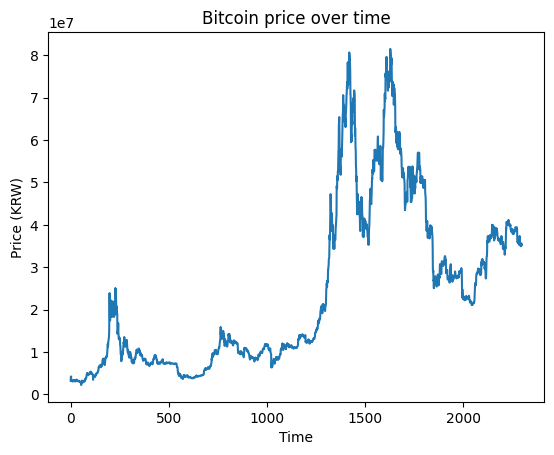

In [ ]:
plt.plot(y)
plt.xlabel("Time")
plt.ylabel("Price (KRW)")
plt.title("Bitcoin price over time")
plt.show();

In [ ]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [ ]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 15, 1)
print(X_ss.shape, y_mm.shape)

(2284, 15, 6) (2284, 1)


In [ ]:
total_samples = len(X)
train_test_cutoff = round(0.60 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (1379, 15, 6) (1379, 1)
Testing Shape: (905, 15, 6) (905, 1)


In [ ]:
import torch
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [ ]:
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 15,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 15,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([1379, 15, 6]) torch.Size([1379, 1])
Testing Shape: torch.Size([905, 15, 6]) torch.Size([905, 1])


In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,6),activation="tanh"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
44/44 [==============================] - 3s 18ms/step - loss: 0.0875 - val_loss: 0.0981
Epoch 2/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0427
Epoch 3/200
44/44 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0215
Epoch 4/200
44/44 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 5/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 6/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0084
Epoch 7/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 8/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0072
Epoch 9/200
44/44 [==============================] - 0s 7ms/step - loss: 9.0118e-04 - val_loss: 0.0068
Epoch 10/200
44/44 [==============================] - 0s 8ms/step - loss: 7.8865e-04 - val_loss: 0.

In [ ]:
buff = closedf
del buff['날짜']
df_X_ss = ss.transform(buff) # old transformers
df_y_mm = mm.transform(closedf['종가'].values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 6, 50)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 6, df_X_ss.shape[2]))

train_predict=model.predict(df_X_ss)
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

#test_predict=model.predict(X_test)

# train_predict = lstm(df_X_ss) # forward pass
# data_predict = train_predict.data.numpy() # numpy conversion
# dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

KeyError: ignored

In [ ]:
model.save("BITCOIN_MODEL_VER2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive

drive.mount('/content/drive')  # mounts the drive

Mounted at /content/drive
